# Data science assessment - Fraud data

Import necessary libraries

In [581]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("seaborn")


## Explore data

First, load data into `DataFrame`.

In [582]:
data = pd.read_csv("Candidate_tech_evaluation_candidate_copy_data science_fraud.csv")
ip_map = pd.read_excel("Candidate_tech_evaluation_candidate_copy_datascience_IpAddress_to_Country.xlsx", 
                       sheet_name="candidate_tech_evaluation_candi")

Because we are dealing with a (binary) classification problem, we want to see the persentage of each class (fraudulent=1, valid=0).

The valid transations account for 90.6% of the dataset, while the fraudulent trasations only have 9.4%. Clearly, we are dealing with imbalanced dataset. If we use this dataframe as the base for our models training and analysis, we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud (even with a dummy model which always predicts "valid", and it can achieve over 90% accuracy). But that's not what we want, we want our model to detect patterns that give signs of fraud. Therefore, we will need to use some sampling techniques to balance the dataset, which will be done later.

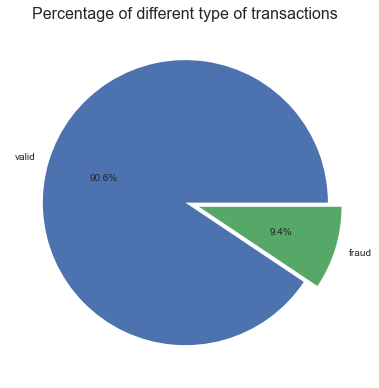

In [583]:
vc =data["class"].value_counts()
labels = np.array(["valid", "fraud"])[vc.index]
plt.pie(vc.values,labels=labels, autopct="%1.1f%%", explode=(0, 0.1))
plt.title("Percentage of different type of transactions", fontsize=16)
plt.tight_layout()
plt.show()

Let's have a closer look on the fraud data.

In [584]:
valid_transactions = data[data["class"] == 0]
fraud_transactions = data[data["class"] == 1].sort_values("signup_time")
fraud_transactions

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
16795,41991,124539,1/1/2015 0:00,1/1/2015 0:00,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1
61276,106161,338656,1/1/2015 0:00,1/1/2015 0:00,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1
73200,140341,143242,1/1/2015 0:00,1/1/2015 0:00,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1
112207,24573,356414,1/1/2015 0:00,1/1/2015 0:00,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1
52291,138677,156748,1/1/2015 0:00,1/1/2015 0:00,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...
103379,77859,55923,8/9/2015 4:49,10/30/2015 0:56,20,EEOPJWPGAZYII,Direct,Chrome,M,38,3.273485e+09,1
31569,89742,84042,8/9/2015 6:23,9/7/2015 19:20,56,RTOLPMQLKEFQI,SEO,IE,F,38,1.470633e+09,1
66456,36088,32294,8/9/2015 8:19,9/6/2015 0:47,65,PEEUIRACOTHCF,Ads,IE,M,39,3.549630e+09,1
53148,22579,116381,8/9/2015 8:30,11/16/2015 15:06,55,LZDSBULLXUQHP,Ads,FireFox,M,34,2.000362e+09,1


### Feature: signup_time and purchase_time

The first intuition we got is that the fraud users usually had the same **signup_time** and **purchase_time**, and those transations often came from the same **device_id** and got the same **ip_address**. 

We suspect that some people use malwares to register different accounts in batches. The moment when the accounts are created, they will automatically trigger fraudulent transactions. This can explain why the sign-up time and purcharse time happened at the same time, and most of these transactions came from the same devices with the same IPs.

The plot below shows **52.7%** of the fraud transactions have the same **signup_time** and **purchase_time**.

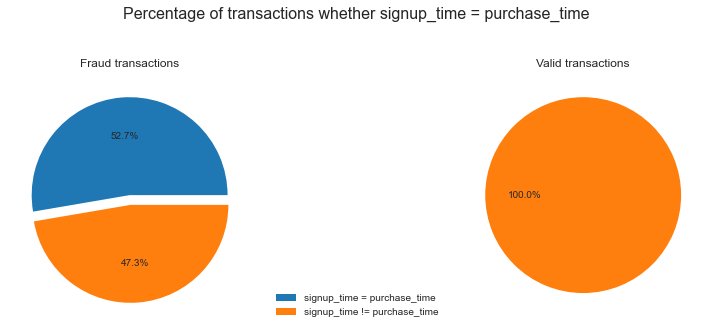

In [585]:
fraud_cnt = (fraud_transactions["signup_time"] == fraud_transactions["purchase_time"]).value_counts()
valid_cnt = (valid_transactions["signup_time"] == valid_transactions["purchase_time"]).value_counts()

colors = [u"#1f77b4", u"#ff7f0e"]
labels = ["signup_time = purchase_time", "signup_time != purchase_time"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pie(fraud_cnt.values, autopct="%1.1f%%", explode=(0, 0.1), colors=colors)
axs[1].pie(valid_cnt.values, autopct="%1.1f%%", colors=[colors[1]])
axs[0].legend(labels, loc="right", bbox_to_anchor=(1.8, 0.05))
axs[0].title.set_text("Fraud transactions", )
axs[1].title.set_text("Valid transactions")
fig.suptitle("Percentage of transactions whether signup_time = purchase_time", fontsize=16)
plt.tight_layout()
plt.show()

### Feature: device_id

We also want to inspect if the same device appear more frequently in fraudulent transactions than in valid transactions. The grpah below shows in some devices are being used more than once in 16.2% of the fraud transactions.

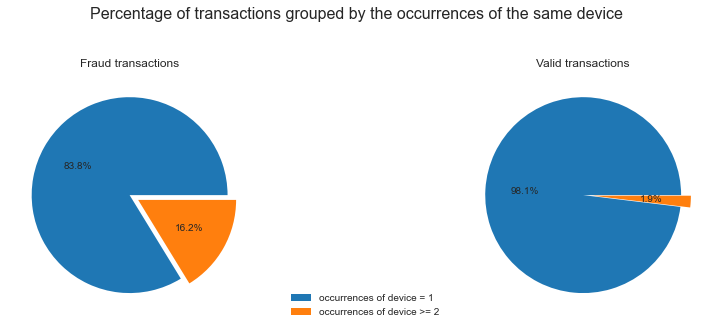

In [586]:
v = valid_transactions["device_id"].value_counts().value_counts()
v_cnt = v.groupby(np.where(v.index > 1, ">= 2", v.index)).sum()
f = fraud_transactions["device_id"].value_counts().value_counts()
f_cnt = f.groupby(np.where(f.index > 1, ">= 2", f.index)).sum()

labels = ["occurrences of device = 1", "occurrences of device >= 2"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pie(f_cnt.values, autopct="%1.1f%%", explode=(0, 0.1), colors=colors)
axs[1].pie(v_cnt.values, autopct="%1.1f%%", explode=(0, 0.1), colors=colors)
axs[0].legend(labels, loc="right", bbox_to_anchor=(1.8, 0.05))
axs[0].title.set_text("Fraud transactions")
axs[1].title.set_text("Valid transactions")
fig.suptitle("Percentage of transactions grouped by the occurrences of the same device", fontsize=16)
plt.tight_layout()
plt.show()

### Feature: ip_address

We can also apply the same approach above to inspect IPs. We got 12.7% of the fraud transactions where same IP addresses occured more than once.

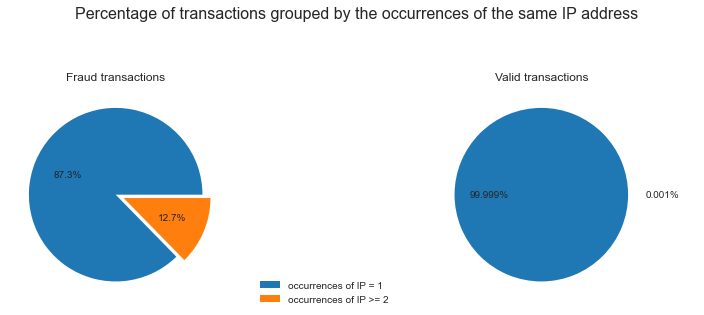

In [587]:
n = valid_transactions["ip_address"].value_counts().value_counts()
v_cnt = n.groupby(np.where(n.index > 1, ">= 2", n.index)).sum()
f = fraud_transactions["ip_address"].value_counts().value_counts()
f_cnt = f.groupby(np.where(f.index > 1, ">= 2", f.index)).sum()
labels = ["occurrences of IP = 1", "occurrences of IP >= 2"]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pie(f_cnt.values, autopct="%1.1f%%", explode=(0, 0.1), colors=colors)
axs[1].pie(v_cnt.values, autopct="%1.3f%%", explode=(0, 0.8), colors=colors)
axs[0].legend(labels, loc="right", bbox_to_anchor=(1.8, 0.05))
axs[0].title.set_text("Fraud transactions")
axs[1].title.set_text("Valid transactions")
fig.suptitle("Percentage of transactions grouped by the occurrences of the same IP address", fontsize=16)
plt.tight_layout()
plt.show()

Since we can map ip address to country using **ip_map** DataFrame, we can also investigate if the frequency of fraud transactions is related to different regions.

> **Notice**: If an IP address can't be mapped to any existing country in ip_map, it will be marked as **Unknown Country**.

In [588]:
def get_country_from_ip(ip):
    country = ip_map[(ip_map["lower_bound_ip_address"] <= ip) & \
                        (ip_map["upper_bound_ip_address"] >= ip)]["country"]
    return "Unknown Country" if country.empty else country.values[0]

v_cnt = valid_transactions["ip_address"].apply(lambda ip: get_country_from_ip(ip)).value_counts().sort_values(ascending=False)
f_cnt = fraud_transactions["ip_address"].apply(lambda ip: get_country_from_ip(ip)).value_counts().sort_values(ascending=False)

From the result, we learn that the top-6 country ranking between fraud transactions and valid transactions is identical, and 19 out of the top 20 in both transactions are overlapped. Therefore, the regions with more valid transactions also have a higher frequency of fraudulent transactions, and they are positively correlated. Here we assume "**Unknown country**" (2nd place) is also counted as a "real country".

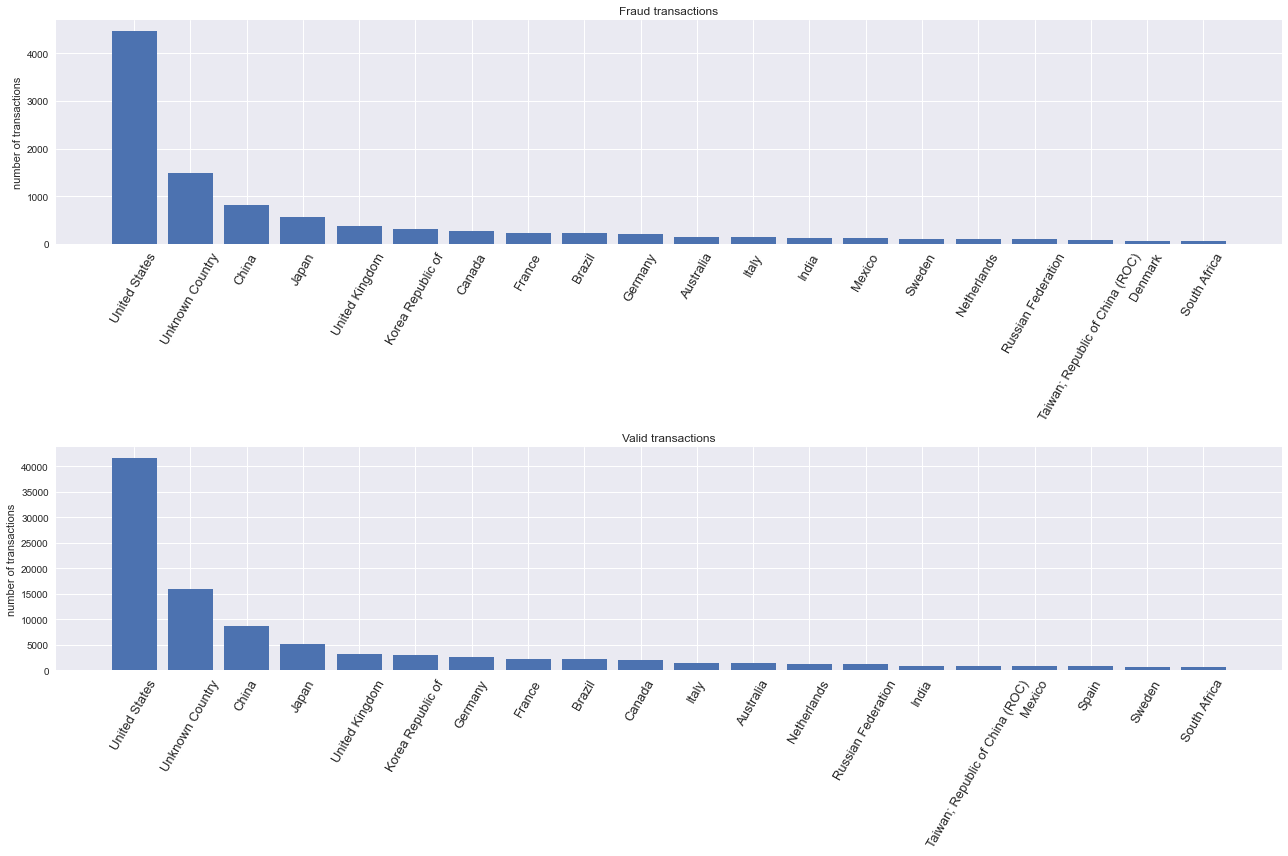

In [589]:
n = 20
v_head = v_cnt.head(n)
f_head = f_cnt.head(n)

fig, axs = plt.subplots(2, 1, figsize=(18, 12))
axs[0].bar(f_head.index, f_head.values)
axs[1].bar(v_head.index, v_head.values)
axs[0].title.set_text("Fraud transactions")
axs[1].title.set_text("Valid transactions")
axs[0].tick_params(axis="x", rotation=60, labelsize=13)
axs[1].tick_params(axis="x", rotation=60, labelsize=13)
axs[0].set_ylabel("number of transactions"), axs[1].set_ylabel("number of transactions")
plt.tight_layout()
plt.show()

### Feature: source, browser and sex

Probably source, browser and sex don't have much say in distinguishing between fraud and valid transactions. But it won't hurt to plot out the distrubutions.

In [590]:
def plot_cat_feature(feature):
    f_cnt = fraud_transactions[feature].value_counts().sort_index()
    v_cnt = valid_transactions[feature].value_counts().sort_index()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].pie(f_cnt.values, autopct="%1.1f%%")
    axs[1].pie(v_cnt.values, autopct="%1.1f%%")
    axs[0].legend(v_cnt.index, loc="right", bbox_to_anchor=(1.2, 0.05))
    axs[0].title.set_text("Fraud transactions")
    axs[1].title.set_text("Valid transactions")
    fig.suptitle(f"Percentage of transactions grouped by {feature}", fontsize=16)
    plt.tight_layout()
    plt.show()

As expected，the distribution of source, browser, sex between fraud transactionss and valid transactions are almost identical, which means these 3 categorical features have very limited influence on fraud detection. 

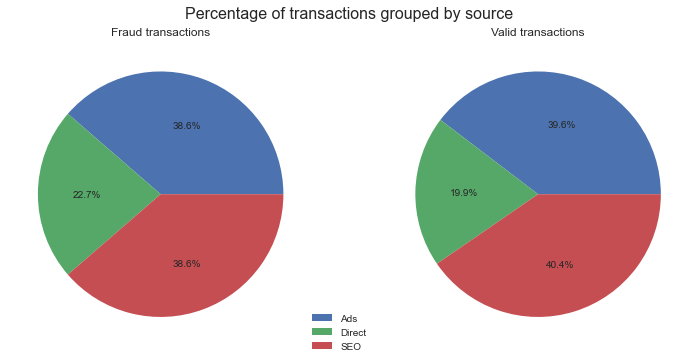

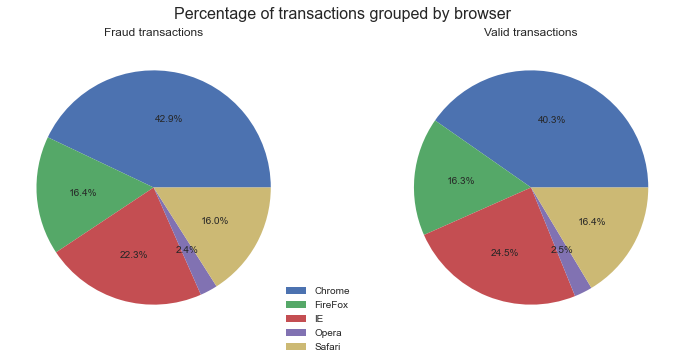

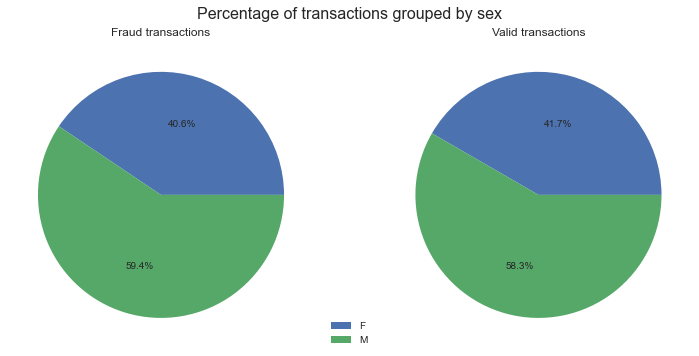

In [591]:
plot_cat_feature("source")
plot_cat_feature("browser")
plot_cat_feature("sex")


### Feature: purchase_value and age

The last features we want to inspect are purchase_value and age. Since both are continuous features, we are going to use histogram to plot out the distributions.

The data has totally 120,000 rows and 12 columns. Since the first column [Unnamed: 0] is actually the row index, which has no use for us. So we drop it.

In [592]:
def plot_cont_feature(feature):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].hist(fraud_transactions[feature])
    axs[1].hist(valid_transactions[feature])
    axs[0].title.set_text("Fraud transactions")
    axs[1].title.set_text("Valid transactions")
    axs[0].set_xlabel(feature), axs[0].set_ylabel("number of transactions")
    axs[1].set_xlabel(feature)
    fig.suptitle(f"Distribution of transactions based on {feature}", fontsize=16)
    plt.tight_layout()
    plt.show()

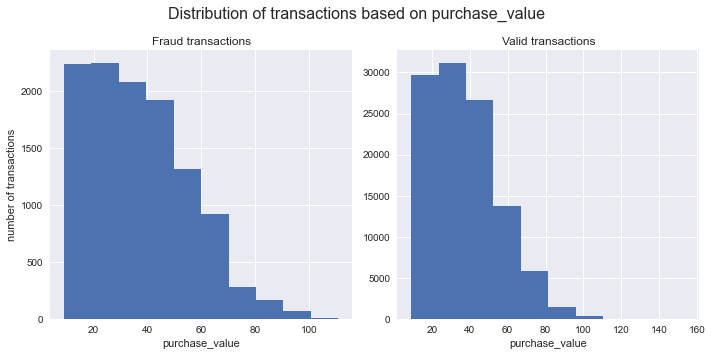

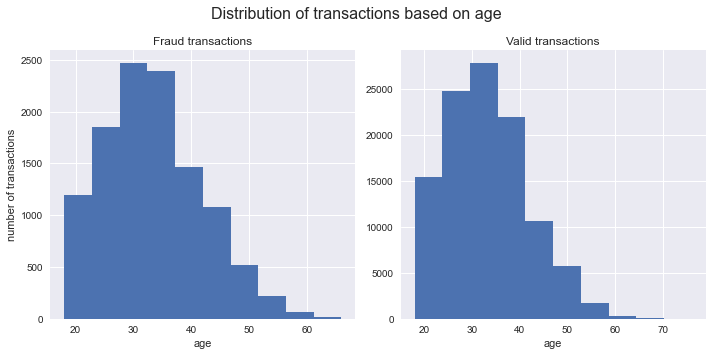

In [593]:
plot_cont_feature("purchase_value")
plot_cont_feature("age")

### Summary after data exploration

After data exploration, we can draw the following conclusions regarding to different features.
- Feature **Unnamed: 0** should be dropoed since it's just a dummy column recording the row index.
- Feature **user_id** should be dropoed, because according to the problem description, the dataset only contains the information about **first transaction of a new user** on Electronica’s website, which means this column is like row index, always unique.
- Feature **signup_time** and **purchase_time** are very important. They can be used to calculate the time difference between sign-up and first purchase, which is very useful for distinguishing fraud transactions.
- Feature **device_id** looks useful on separating fraud from valid transactions. But since **device_id** belongs to categorical feature, we have to encode it into discret values for model training, which doesn't make lots of sense. Firstly, the data contains so many unique **device_id**s, and those IDs looks irrelevant, and it doesn't make sense to map each ID to a ramdom number (probably using hash to generate a value). Secondly, if the test data contains a new **device_id** which doesn't exists in training set, our model will have a problem. Plus, there are nearly infinite devices on the world, which means there will be infinite **device_id**s. Fraud transactions can theoretically happen on any devices that can perform online-transactions. For simplicity, here we drop **device_id** for model training.
- Feature **ip_adress** can be used to calculate feature **country**, but based on the result above,it doesn't seem to help us distinguish fraud from valid (which really doesn't, becasue I tried to train the model in the following sections with and without **country**, and it doesn't help improve the model's performances, maybe a little improvements and it depends on models). But here we still save this feature for later use.
- Based on plotting, categorical features **source**, **browser** and **sex** also seems to have very little influence either (Spoil alert: It turns out to be true in the model traning and evaluation later).
- Likewise continuous features **purchase_value** and **age** also have very limited impact (Spoil alert: It also turns out to be true later).


## Feature engineering, model training and evaluation

In [594]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, BalancedBaggingClassifier, EasyEnsembleClassifier

Because of the time limitation, here I only experiment and play with the emsemble ML algorithms (random forest, AdaBoost, etc). 

### Prepare data before training

In [595]:
random_state = 2022
ord_encoder = None
std_scaler = None

def cal_diff_time(X: pd.DataFrame) -> pd.DataFrame:
    """Calculate diff_time from sighup_time and purchase_time.

    Args:
        X (pd.DataFrame): Input data.

    Returns:
        pd.DataFrame: Output data.
    """
    s_time = pd.to_datetime(X["signup_time"], format="%m/%d/%Y %H:%M")
    p_time = pd.to_datetime(X["purchase_time"], format="%m/%d/%Y %H:%M")
    X["diff_time"] = (p_time - s_time).apply(lambda diff: diff.total_seconds())
    # Drop signup_time, purchase_time
    return X.drop(columns=["signup_time", "purchase_time"])

def ip2country(X: pd.DataFrame) -> pd.DataFrame:
    """Calculate country from ip_address.

    Args:
        X (pd.DataFrame): Input data.

    Returns:
        pd.DataFrame: Output data.
    """
    # """Calculate country from ip address."""
    def get_country(ip):
        country = ip_map[(ip_map["lower_bound_ip_address"] <= ip) & \
                         (ip_map["upper_bound_ip_address"] >= ip)]["country"]
        return "Unknown Country" if country.empty else country.values[0]

    X["country"] = X["ip_address"].apply(lambda ip: get_country(ip))
    # Drop ip_address
    return X.drop(columns=["ip_address"])

def prepare_data(X: pd.DataFrame) -> pd.DataFrame:
    """Prepare data. 

    Perform all necessary data preprocessing operations for model training.

    Args:
        X (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    # Drop index column
    try:
        X = X.drop(columns=["Unnamed: 0"])
    except:
        pass
    # Drop user_id and device_id
    X = X.drop(columns=["user_id", "device_id"])
    # Calculate diff_time from purchase_time and signup_time
    X = cal_diff_time(X)
    # Calculate country from ip_address
    X = ip2country(X)

    global ord_encoder, std_scaler
    if not ord_encoder:
        # Encode catogorical features
        ord_encoder = OrdinalEncoder().fit(X[["source", "browser", "sex", "country"]])
    if not std_scaler:
        # Standardize continuous features
        std_scaler = StandardScaler().fit(X[["purchase_value", "diff_time", "age"]])
    X[["source", "browser", "sex", "country"]] = ord_encoder.transform(X[["source", "browser", "sex", "country"]])
    X[["purchase_value", "diff_time", "age"]] = std_scaler.transform(X[["purchase_value", "diff_time", "age"]])
    
    # Drop or not? Compare model performances with/without these features.
    # X = X.drop(columns=["source", "browser", "sex", "country", "purchase_value", "age"])
    return X

Split data into training set (70%) and test set (30%).

In [596]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=random_state)
X , y = data.drop(columns=["class"]), data["class"]
X = prepare_data(X)

for train_i, test_i in sss.split(X, y):
    X_train, X_test = X.iloc[train_i], X.iloc[test_i]
    y_train, y_test = y[train_i], y[test_i]

### Train models

Here I use ensemble models from "imbalanced-learn" (which uses scikit-learn as backend engineer) to deal with imbalanced dataset.

In [597]:
# Here we set the number of base estimators as 100.
n_estimators = 100

clfs = {
    "brf": BalancedRandomForestClassifier(n_estimators=n_estimators, random_state=random_state),
    "rus": RUSBoostClassifier(n_estimators=n_estimators, random_state=random_state),
    "bbc": BalancedBaggingClassifier(n_estimators=n_estimators, random_state=random_state),
    "eec": EasyEnsembleClassifier(n_estimators=n_estimators, random_state=random_state)
}

for name, clf in clfs.items():
    clf.fit(X_train, y_train)

### Evaluate models

The evaluation metrics used here includes balanced accuracy score (average of recall for each classes) and confusion matrix to measure the performance of BalancedRandomForestClassifier, RUSBoostClassifier, BalancedBaggingClassifier and EasyEnsembleClassifier.

And the final results show that all the ensemble methods achieve similar scores (75% ~ 77%). Among which, RUSBoostClassifier and EasyEnsembleClassifier have quite close scores (77.08% and 77.06% respectively), while BalancedRandomForestClassifier has the lowest score (75.67%).

If we choose the best model for this perticular use case, **RUSBoostClassifier** wins the race by a narrow margin. And if we have a look of the feature importances, **diff_time** acoounts for 94% of the importances, the other features are all less than 4%. Actually I tried to drop all the features except **diff_time** and traning the model again. The performance of RUSBoostClassifier even slightly improved (77.11%).
However, the performances of BalancedRandomForestClassifier and BalancedBaggingClassifier dropped relatively large (respectively 70.39% and 72.57%). That means if we choose RUSBoostClassifier as our final model, we can just use **diff_time** (or **purchase_time** - **signup_time**) for training.

Balanced accuracy score (average of recall) for brf:  75.67%
Feature importances (if available):
diff_time         0.549965
purchase_value    0.158249
age               0.132238
country           0.086552
browser           0.034666
source            0.021910
sex               0.016419


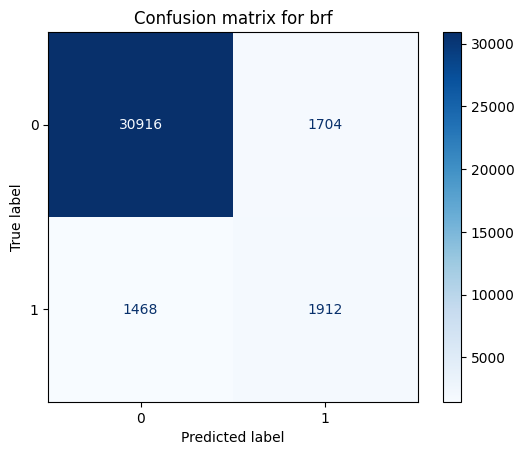

Balanced accuracy score (average of recall) for rus:  77.08%
Feature importances (if available):
diff_time         0.92
country           0.04
purchase_value    0.03
source            0.01
browser           0.00
sex               0.00
age               0.00


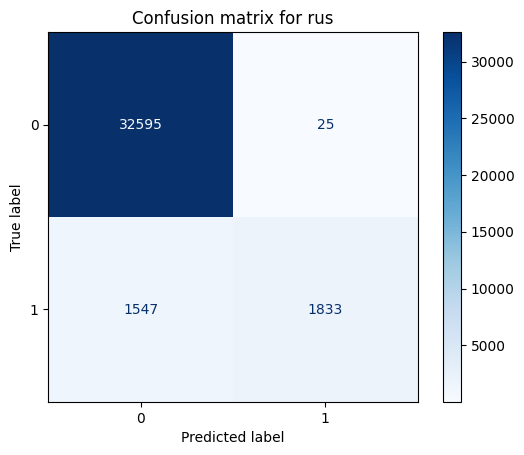

Balanced accuracy score (average of recall) for bbc:  76.67%


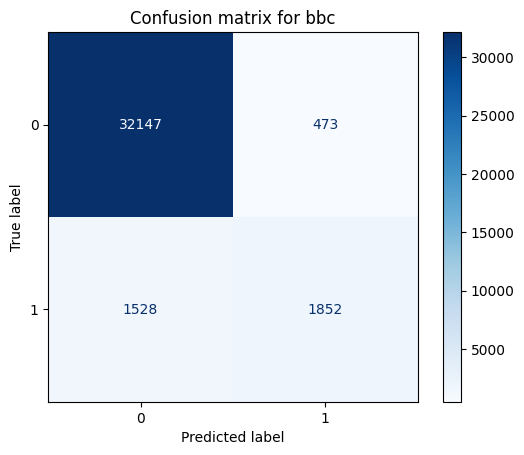

Balanced accuracy score (average of recall) for eec:  77.06%


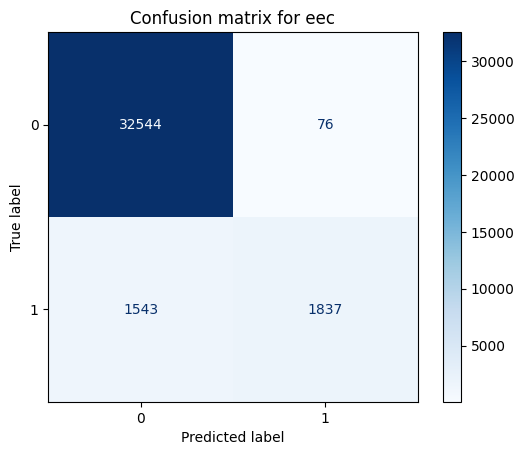

In [598]:
plt.style.use("default")

for name, clf in clfs.items():
    y_pred = clf.predict(X_test)
    bas = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced accuracy score (average of recall) for {name}: {bas: .2%}")
    try:
        fi = pd.Series(data=clf.feature_importances_,index=X_train.columns)
        fi.sort_values(ascending=False,inplace=True)
        print(f"Feature importances (if available):\n{fi.to_string()}")
    except:
        pass
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=clf.classes_, cmap=plt.cm.Blues)
    disp.ax_.set_title(f"Confusion matrix for {name}")
    plt.show()

### Final words

Obvisouly, there are lots of rooms for improvements.

- Try different types of models (SVC, neural networks, etc).
- Fine-tune and cross-validate each models.
- Try to make use of feature **device_id**. Some devices have obviously very high tedency to perform fraud transactions. These devices could be intentionally designed and used for fraud transactions. We could probably build some mechanisms like "black list" to record these devices. Whenever a transaction is performed by these devices, the system should be alerted, because there is a high prosibility that this transaction is fraudulent. Maybe assign higher sample weight on "fraud" devices.
- Try to leverage the information: if a valid transactions is wrongly classified as "fraud", the company will lose money ($8). But if a fraud transactions is wrongly flagged as "valid", the company will lose money equivalent to the item value. We can use this knowledge to build a custom loss function somehow, and try to train and optimize the model by minimizing the loss.

But just like I said before, due to the limited time, I don't have the energy to dive deeper and research further.